# データが大きすぎるために起きる問題点と解決策

- 提出元データ
    - 現状候補となるレコードが数十億(6000 * 600000)あり、特徴量エンジニアリングに時間がかかってしまう
        - 学習用バリデーションデータでpdcaを早く回したいので、せめて数千万程度にしたい
    - 正解となるレコードがより多く含まれている状態にしたい

- 学習用データ
    - 提出時に含まれるデータと同じような分布になって欲しいため、同じような前処理で作成したい
        - 同じように作成した場合は、特徴量エンジニアリングに時間がかかってしまう
    - データが多過ぎると、lightgbmのアンサンブルにしても時間がかかる
    - 正解データは多く持っていた方が良いと思われる
    - とりあえず正解データに適当にサンプリングしたオークションを付け加えたらどうにかなりそう?
    
- 学習用バリデーションデータ
    - 提出用データ作成時と同様の処理をすることを考えると、特徴量エンジニアリングに時間がかかってしまう
        - 学習用バリデーションデータでpdcaを早く回したいので、せめて数千万程度にしたい    
        
tobe
- 提出元データ
    - 数千万程度で、正解となるレコードがより多く含まれている状態にしたい
- 学習用バリデーションデータ
    - 提出元データと同じ
- 学習用データ
    - 数千万程度、提出用データと同じような分布を持っており、提出時に無いようなデータに過学習しない

In [1]:
from os.path import dirname
import os
import datetime
from dateutil.relativedelta import relativedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
import brandear_est as be

In [4]:
INPUT_DIR = os.path.join(os.getcwd(), "../../data/input/")
IMD_DIR = os.path.join(os.getcwd(), "../../data/intermediate/")

In [5]:
dset_to_period = {
    "train": {"oldest": datetime.datetime(2019, 9, 3, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 10, 0, 0, 0)},
    "valid_for_train": {"oldest": datetime.datetime(2019, 9, 10, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 17, 0, 0, 0),},
    "valid_for_sub": {"oldest": datetime.datetime(2019, 9, 17, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 24, 0, 0, 0),}
}

In [6]:
auction = be.read_csv(INPUT_DIR + "auction.csv")
watch = be.read_csv(INPUT_DIR + "watchlist.csv")
bid = be.read_csv(INPUT_DIR + "shudounyuusatsu.csv")
bid_success = be.read_csv(INPUT_DIR + "rakusatsu.csv")

watch.rename(columns={"TourokuDate": "ActionDate"}, inplace=True)
bid.rename(columns={"ShudouNyuusatsuDate": "ActionDate"}, inplace=True)
watch = be.to_datetime(watch)
bid = be.to_datetime(bid)

Mem. usage decreased to 137.17 Mb (66.3% reduction)
Mem. usage decreased to 67.53 Mb (46.9% reduction)
Mem. usage decreased to 13.44 Mb (58.9% reduction)
Mem. usage decreased to  9.45 Mb (54.2% reduction)


In [7]:
watch = watch.merge(auction, on="AuctionID")
bid = bid.merge(auction, on="AuctionID")

In [28]:
def extract_target_aucs(watch, bid, dset_to_period, dset_type):
    """対象期間中に発生したアクションを抽出"""
    oldest_dtime, newest_dtime = (
        dset_to_period[dset_type]["oldest"],
        dset_to_period[dset_type]["newest"]
    )    
    watch_actioned = (
        watch[(watch["ActionDate"] >= oldest_dtime) & (watch["ActionDate"] < newest_dtime)]
    )
    bid_actioned = (
        bid[(bid["ActionDate"] >= oldest_dtime) & (bid["ActionDate"] < newest_dtime)]
    )
    target_aucs = (
        pd.concat([watch_actioned, bid_actioned], sort=False)
    )
    return target_aucs

In [27]:
def merge_choiced_aucs(target_users, watch, bid, auction, oldest_dtime, col="ShouhinID"):
    # choiced_auc付与部分
    # あるユーザーが現在までにアクションをした商品と同じ商品IDのオークションを抽出
    # これが関数内で作成する学習データの大元
    
    # リークを防ぐため、特徴量、choiced_auc作成用のデータから正解データ抽出期間時のデータを削除する
    watch_train = (
        watch_targeted[watch_targeted["ActionDate"] < oldest_dtime]
        .merge(target_users, on="KaiinID")
    )
    watch_train["watch_actioned"] = 1
    bid_train = (
        bid_targeted[bid_targeted["ActionDate"] < oldest_dtime]
        .merge(target_users, on="KaiinID")
    )
    bid_train["bid_actioned"] = 1
    
    target_aucs = (
        pd.concat([watch[["KaiinID", col]], bid[["KaiinID", col]]])
            .drop_duplicates()
            .merge(auction[["AuctionID", col]], on=col)[["KaiinID", "AuctionID"]]
            .drop_duplicates()
    )

    auc_cols = (
        ['AuctionID', 'ShouhinShubetsuID', 'ShouhinID', 'SaishuppinKaisuu',
         'ConditionID', 'BrandID', 'GenreID', 'GenreGroupID', 'LineID',
         'DanjobetsuID']
    )

    # 今回の対象ユーザーに絞る
    target_data = (
        target_users
            .merge(target_aucs, on="KaiinID")
            .merge(auction[auc_cols], on="AuctionID")
    )

    return target_data


In [20]:
def merge_users_actions(target_users, watch, bid, auction, oldest_dtime):
    # choiced_auc付与部分
    # あるユーザーが現在までにアクションをした商品と同じ商品IDのオークションを抽出
    # これが関数内で作成する学習データの大元
    
    # リークを防ぐため、特徴量、choiced_auc作成用のデータから正解データ抽出期間時のデータを削除する
    watch_target = (
        watch[watch["ActionDate"] < oldest_dtime]
        .merge(target_users, on="KaiinID")
    )
    bid_target = (
        bid[bid["ActionDate"] < oldest_dtime]
        .merge(target_users, on="KaiinID")
    )
    
    users_actions = (
        pd.concat([watch_target,bid_target], sort=False)
            .merge(target_users, on="KaiinID")
    )

    return users_actions


In [43]:
def get_sample_aucs(action, watch, bid_success, dset_to_period, dset_type):
    
    sample_aucs = be.left_anti_join(
        auction[(auction["CreateDate"] > start_dt - relativedelta(months=2)) &
                 (auction["CreateDate"] < end_dt)][["AuctionID"]],
        bid_success, "AuctionID", "AuctionID"
    )

    return sample_aucs

## 一部のサンプルユーザーを用いて、決定木分析で予測してみる?

In [9]:
traget_aucs = extract_target_aucs(watch,bid, dset_to_period, "train")

In [36]:
sample_ans = traget_aucs[["KaiinID"] + list(auction.columns)].drop_duplicates().sample(n=100)

In [42]:
sample_ans.head()

,KaiinID,AuctionID,ShouhinShubetsuID,ShouhinID,SaishuppinKaisuu,ConditionID,BrandID,GenreID,GenreGroupID,LineID,ColorID,DanjobetsuID,SankouKakaku,CreateDate
1121214,63188,1514526,1,266549,0,6,79,338,35,0,15,2,3000,2019-07-27 09:35:57
1099466,125555,564028,1,384986,0,7,2971,33,33,0,0,2,3000,2019-09-05 09:33:09
1097180,110604,2375720,1,211226,0,7,69,13,13,0,0,2,3500,2019-05-30 09:37:22
852354,221780,2815663,1,770088,0,9,10390,15,24,0,0,2,12000,2019-08-09 09:36:18
946395,115034,2527624,1,2967940,107,5,66,9,9,0,0,1,40000,2018-12-12 09:30:18


## 商品以外のもので履歴を探した時にどのくらいの正解率含有割合を作れるか

In [7]:
def build_dataset(watch, bid, auction, dset_type, dset_to_period, target_users=None, col="ShouhinID"):
    oldest_dtime, newest_dtime = (
        dset_to_period[dset_type]["oldest"],
        dset_to_period[dset_type]["newest"]
    )

    # データセット作成の対象となるユーザー一覧
    if dset_type != "submission":
        watch_actioned = (
            watch[(watch["ActionDate"] >= oldest_dtime) & (watch["ActionDate"] < newest_dtime)]
        )
        bid_actioned = (
            bid[(bid["ActionDate"] >= oldest_dtime) & (bid["ActionDate"] < newest_dtime)]
        )
        target_users = (
            pd.concat([watch_actioned, bid_actioned], sort=False)[["KaiinID"]]
            .drop_duplicates()
        )
        
    watch_targeted = watch.merge(target_users, on="KaiinID")
    bid_targeted = bid.merge(target_users, on="KaiinID")

    # リークを防ぐため、特徴量、choiced_auc作成用のデータから正解データ抽出期間時のデータを削除する
    watch_train = watch_targeted[watch_targeted["ActionDate"] < oldest_dtime]
    bid_train = bid_targeted[bid_targeted["ActionDate"] < oldest_dtime]

    # 予測対象とするオークションをルール,0次ベースのロジックで限定する
    dataset = merge_choiced_aucs(target_users, watch_train, bid_train, auction, col)

    # 正解データ付与
    if dset_type != "submission":
        watch_actioned["watch_actioned"] = 1
        bid_actioned["bid_actioned"] = 1
        dataset = (
            dataset
                .merge(watch_actioned[["KaiinID", "AuctionID", "watch_actioned"]], on=["KaiinID", "AuctionID"],
                       how="left")
                .merge(bid_actioned[["KaiinID", "AuctionID", "bid_actioned"]], on=["KaiinID", "AuctionID"], how="left")
                .fillna(0)
        )

    return dataset

    

In [8]:
def merge_choiced_aucs(target_users, watch, bid, auction, col="ShouhinID"):
    # choiced_auc付与部分
    # あるユーザーが現在までにアクションをした商品と同じ商品IDのオークションを抽出
    # これが関数内で作成する学習データの大元
    target_aucs = (
        pd.concat([watch[["KaiinID", col]], bid[["KaiinID", col]]])
            .drop_duplicates()
            .merge(auction[["AuctionID", col]], on=col)[["KaiinID", "AuctionID"]]
            .drop_duplicates()
    )

    auc_cols = (
        ['AuctionID', 'ShouhinShubetsuID', 'ShouhinID', 'SaishuppinKaisuu',
         'ConditionID', 'BrandID', 'GenreID', 'GenreGroupID', 'LineID',
         'DanjobetsuID']
    )

    # 今回の対象ユーザーに絞る
    target_data = (
        target_users
            .merge(target_aucs, on="KaiinID")
            .merge(auction[auc_cols], on="AuctionID")
    )

    return target_data


In [ ]:
dset_type = "train"
col_dset = {}
for col in ["ShouhinID", "BrandID", "GenreID", "GenreGroupID", "LineID", "ColorID", "DanjobetsuID"]:
    print(col)
    col_dset[col] = build_dataset(watch, bid, auction, dset_type, dset_to_period, target_users=None, col=col)
    print(col_dset[col][["watch_actioned", "bid_actioned"]].sum())
    print(col_dset[col].shape[0])

ShouhinID


/Users/nobuyuki.ishida/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/nobuyuki.ishida/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


watch_actioned    3302.0
bid_actioned      3718.0
dtype: float64
3284142
BrandID


## アクションを起こしたユーザーがどのくらい同じ商品にアクションするかを調べる

In [12]:
def extract_target_actions(watch, bid, dset_to_period, dset_type):

    oldest_dtime, newest_dtime = (
        dset_to_period[dset_type]["oldest"],
        dset_to_period[dset_type]["newest"]
    )
    watch_actioned = (
        watch[(watch["ActionDate"] >= oldest_dtime) & (watch["ActionDate"] < newest_dtime)]
    )
    bid_actioned = (
        bid[(bid["ActionDate"] >= oldest_dtime) & (bid["ActionDate"] < newest_dtime)]
    )
    target_actions = (
        pd.concat([watch_actioned, bid_actioned], sort=False)
    )
    return target_actions

In [13]:
def extract_users_actions(users, auction, watch, bid, rakusatsu,oldest_dtime):

    actions = (
        pd.concat([watch[watch["ActionDate"] < oldest_dtime],
                        bid[bid["ActionDate"] < oldest_dtime]], sort=False)
    )
    
    users_actions = users.merge(actions, on="KaiinID").merge(auction, on="AuctionID")
    
    return users_actions

In [20]:
dset_to_period["201909"] = {"oldest": datetime.datetime(2019, 9, 1, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 24, 0, 0, 0)}
actions = extract_target_actions(watch, bid, dset_to_period, "201909")

In [23]:
oldest_dtime = dset_to_period["201909"]["oldest"]
users_actions = extract_users_actions(actions[["KaiinID"]].drop_duplicates(), auction, watch, bid, bid_success, oldest_dtime)

In [24]:
users_actions.head()

,KaiinID,AuctionID,ActionDate,SakujoFlag,Kingaku,Suuryou,SokketsuFlag,ShouhinShubetsuID,ShouhinID,SaishuppinKaisuu,ConditionID,BrandID,GenreID,GenreGroupID,LineID,ColorID,DanjobetsuID,SankouKakaku,CreateDate
0,56840,681350,2018-09-20 17:34:19,1,NaN,NaN,NaN,1,1879243,0,6,4341,33,33,0,0,2,7800,2018-08-16 10:51:32
1,140863,681350,2018-09-14 23:23:50,1,NaN,NaN,NaN,1,1879243,0,6,4341,33,33,0,0,2,7800,2018-08-16 10:51:32
2,56840,2544841,2018-09-20 17:44:18,1,NaN,NaN,NaN,1,2320686,0,7,4341,82,19,0,0,2,3500,2018-08-25 11:11:21
3,72870,2544841,2018-09-03 07:15:47,1,NaN,NaN,NaN,1,2320686,0,7,4341,82,19,0,0,2,3500,2018-08-25 11:11:21
4,72870,2544841,2018-09-29 21:26:06,1,NaN,NaN,NaN,1,2320686,0,7,4341,82,19,0,0,2,3500,2018-08-25 11:11:21


In [25]:
for col in ["ShouhinID", "ShouhinShubetsuID", "ConditionID", "BrandID", "GenreID", "GenreGroupID", "LineID", "ColorID"]:
    print((users_actions[["KaiinID", col]].groupby("KaiinID").nunique() / users_actions[["KaiinID", col]].groupby("KaiinID").count()).mean())

KaiinID           NaN
ShouhinID    0.865876
dtype: float64
KaiinID                   NaN
ShouhinShubetsuID    0.067124
dtype: float64
ConditionID    0.131588
KaiinID             NaN
dtype: float64
BrandID    0.279623
KaiinID         NaN
dtype: float64
GenreID    0.226106
KaiinID         NaN
dtype: float64
GenreGroupID    0.151877
KaiinID              NaN
dtype: float64
KaiinID         NaN
LineID     0.072249
dtype: float64
ColorID    0.206427
KaiinID         NaN
dtype: float64


(array([1205.,  685.,  503.,  356.,  321.,  281.,  238.,  212.,  197.,
         195.,  167.,  144.,  128.,  150.,  140.,  115.,  112.,  112.,
          97.,  111.,  101.,   70.,   81.,   91.,   66.,   60.,   56.,
          62.,   58.,   61.,   47.,   45.,   51.,   42.,   63.,   40.,
          54.,   38.,   52.,   38.,   38.,   50.,   36.,   36.,   42.,
          46.,   43.,   36.,   33.,   21.,   35.,   47.,   31.,   16.,
          18.,   26.,   30.,   18.,   16.,   24.,   18.,   26.,   19.,
          30.,   18.,   20.,   27.,   16.,   20.,   23.,   19.,   14.,
          13.,   16.,   16.,   13.,   14.,   11.,   15.,   16.,   14.,
          10.,   15.,   12.,   11.,    4.,   18.,   11.,   10.,   22.,
          15.,    7.,    8.,    5.,   10.,    7.,    5.,   11.,   10.,
          10.]),
 array([  1.  ,  10.98,  20.96,  30.94,  40.92,  50.9 ,  60.88,  70.86,
         80.84,  90.82, 100.8 , 110.78, 120.76, 130.74, 140.72, 150.7 ,
        160.68, 170.66, 180.64, 190.62, 200.6 , 210.58, 22

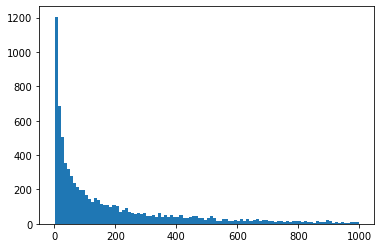

In [45]:
action_cnts = users_actions["KaiinID"].value_counts()
plt.hist(action_cnts[action_cnts < 1000], bins=100)

In [49]:
actions = pd.concat([watch, bid]).merge(auction, on="AuctionID")

/Users/nobuyuki.ishida/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


114     290128
38      188225
12      168337
32      137865
25      119777
         ...  
7478         1
2303         1
9785         1
8906         1
9279         1
Name: BrandID, Length: 6820, dtype: int64

In [50]:
brand = pd.read_csv(INPUT_DIR + "brand.csv")

(array([6.711e+03, 1.200e+01, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.000000e+00, 2.901370e+04, 5.802640e+04, 8.703910e+04,
        1.160518e+05, 1.450645e+05, 1.740772e+05, 2.030899e+05,
        2.321026e+05, 2.611153e+05, 2.901280e+05]),
 <a list of 10 Patch objects>)

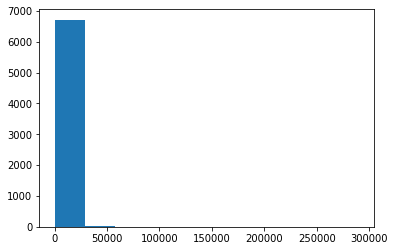

In [58]:
plt.hist(actions.merge(brand, on="BrandID")["BrandName1"].value_counts(), label="index")